In [1]:
import os
import h5py
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
from shapely.geometry import shape, LineString
from scipy.ndimage import measurements

from modis_utils.misc import restore_data, cache_data

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data_dir = 'predict_boundary_samples'
boundary_sample_train, boundary_sample_val, boundary_sample_test = restore_data(
    os.path.join(data_dir, 'inference_boundary_sample.dat'))

In [3]:
boundary_sample_train = boundary_sample_train.reshape(boundary_sample_train.shape[0], -1, 2)
boundary_sample_val = boundary_sample_val.reshape(boundary_sample_val.shape[0], -1, 2)
boundary_sample_test = boundary_sample_test.reshape(boundary_sample_test.shape[0], -1, 2)

In [4]:
groundtruth_dir = 'boundaries_matrix'
groundtruth_train = restore_data(os.path.join(groundtruth_dir, 'train.dat'))
groundtruth_val = restore_data(os.path.join(groundtruth_dir, 'val.dat'))
groundtruth_test = restore_data(os.path.join(groundtruth_dir, 'test.dat'))

In [5]:
groundtruth_train = np.expand_dims(groundtruth_train, axis=-1)
groundtruth_val = np.expand_dims(groundtruth_val, axis=-1)
groundtruth_test = np.expand_dims(groundtruth_test, axis=-1)

In [6]:
boundary_sample_train.shape, boundary_sample_val.shape, boundary_sample_test.shape

((388, 1024, 2), (138, 1024, 2), (138, 1024, 2))

In [7]:
groundtruth_train.shape, groundtruth_val.shape, groundtruth_test.shape

((438, 513, 513, 1), (138, 513, 513, 1), (138, 513, 513, 1))

In [20]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Add, PReLU, Conv2DTranspose, Concatenate
from tensorflow.python.keras.layers import MaxPooling2D, UpSampling2D, Dropout
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.callbacks import Callback
from tensorflow.python.keras import backend as K
import tensorflow as tf


class L0Loss:
    def __init__(self):
        self.gamma = K.variable(2.)

    def __call__(self):
        def calc_loss(y_true, y_pred):
            loss = K.pow(K.abs(y_true - y_pred) + 1e-8, self.gamma)
            return loss
        return calc_loss


class UpdateAnnealingParameter(Callback):
    def __init__(self, gamma, nb_epochs, verbose=0):
        super(UpdateAnnealingParameter, self).__init__()
        self.gamma = gamma
        self.nb_epochs = nb_epochs
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        new_gamma = 2.0 * (self.nb_epochs - epoch) / self.nb_epochs
        K.set_value(self.gamma, new_gamma)

        if self.verbose > 0:
            print('\nEpoch %05d: UpdateAnnealingParameter reducing gamma to %s.' % (epoch + 1, new_gamma))


def tf_log10(x):
    numerator = tf.log(x)
    denominator = tf.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator


def PSNR(y_true, y_pred):
    max_pixel = 255.0
    y_pred = K.clip(y_pred, 0.0, 255.0)
    return 10.0 * tf_log10((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true))))


def get_model(input_shape, model_name="srresnet"):
    if model_name == "srresnet":
        return get_srresnet_model(input_shape)
    elif model_name == "unet":
        return get_unet_model(input_shape)
    else:
        raise ValueError("model_name should be 'srresnet'or 'unet'")


# SRResNet
def get_srresnet_model(input_shape, input_channel_num=1, feature_dim=64, resunit_num=16):
    def _residual_block(inputs):
        x = Conv2D(feature_dim, (3, 3), padding="same", kernel_initializer="he_normal")(inputs)
        x = BatchNormalization()(x)
        x = PReLU(shared_axes=[1, 2])(x)
        x = Conv2D(feature_dim, (3, 3), padding="same", kernel_initializer="he_normal")(x)
        x = BatchNormalization()(x)
        m = Add()([x, inputs])

        return m

    inputs = Input(shape=(input_shape[0], input_shape[1], input_channel_num))
    x = Conv2D(feature_dim, (3, 3), padding="same", kernel_initializer="he_normal")(inputs)
    x = PReLU(shared_axes=[1, 2])(x)
    x0 = x

    for i in range(resunit_num):
        x = _residual_block(x)

    x = Conv2D(feature_dim, (3, 3), padding="same", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Add()([x, x0])
    x = Conv2D(input_channel_num, (3, 3), padding="same", kernel_initializer="he_normal")(x)
    x = Activation('sigmoid')(x)
    model = Model(inputs=inputs, outputs=x)

    return model


# UNet: code from https://github.com/pietz/unet-keras
def get_unet_model(input_shape, input_channel_num=1, out_ch=1, start_ch=64, depth=4, inc_rate=2., 
                   activation='relu', dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
    def _conv_block(m, dim, acti, bn, res, do=0):
        n = Conv2D(dim, 3, activation=acti, padding='same')(m)
        n = BatchNormalization()(n) if bn else n
        n = Dropout(do)(n) if do else n
        n = Conv2D(dim, 3, activation=acti, padding='same')(n)
        n = BatchNormalization()(n) if bn else n

        return Concatenate()([m, n]) if res else n

    def _level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
        if depth > 0:
            n = _conv_block(m, dim, acti, bn, res)
            m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
            m = _level_block(m, int(inc * dim), depth - 1, inc, acti, do, bn, mp, up, res)
            if up:
                m = UpSampling2D()(m)
                m = Conv2D(dim, 2, activation=acti, padding='same')(m)
            else:
                m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
            n = Concatenate()([n, m])
            m = _conv_block(n, dim, acti, bn, res)
        else:
            m = _conv_block(m, dim, acti, bn, res, do)

        return m

    i = Input(shape=(input_shape[0], input_shape[1], input_channel_num))
    o = _level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
    o = Conv2D(out_ch, 1)(o)
    model = Model(inputs=i, outputs=o)

    return model

In [21]:
def boundary_loss(groundtruth, predict):
    groundtruth = tf.to_float(groundtruth)
    predict = tf.to_float(predict)
    square_error = tf.multiply(groundtruth, (groundtruth - predict)**2)
    square_error = tf.reduce_sum(square_error, axis=[1,2,3])
    s = tf.reduce_sum(groundtruth, axis=[1,2,3])
    return tf.divide(square_error, s)

In [22]:
predict_dir = 'predict_boundary'

In [62]:
boundary_sample_test.min(), boundary_sample_test.max()

(0.0, 1.0)

# Inference Phase. Only run one time. If runned, not runned again

In [12]:
os.path.isfile(os.path.join('data_boundary_matrix', 'test.dat'))

True

In [13]:
data_dir = 'data_boundary_matrix'
#data_train = restore_data(os.path.join(data_dir, 'train.dat'))
#data_val = restore_data(os.path.join(data_dir, 'val.dat'))
data_test = restore_data(os.path.join(data_dir, 'test.dat'))

In [14]:
K.clear_session()
model = get_model(input_shape=(513, 513))
model.compile(loss=boundary_loss, optimizer='adam')

In [15]:
model.load_weights('boundary_sample_to_image.h5')

In [17]:
b = data_test[0:1]
b.shape

(1, 513, 513, 1)

Text(0.5,1,'groundtruth')

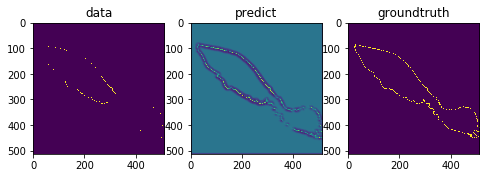

In [114]:
idx = 0
x = model.predict(data_test[idx:idx+1])
fig, ax = plt.subplots(1,3, figsize=(8,20))

data_X_0 = data_test[idx, :, :, 0]
ax[0].imshow(data_X_0)
ax[0].set_title('data')

predict = x.squeeze(axis=0).squeeze(axis=-1)
ax[1].imshow(predict)
ax[1].set_title('predict')

groundtruth = groundtruth_test[idx:idx+1].squeeze(axis=0).squeeze(axis=-1)
ax[2].imshow(groundtruth)
ax[2].set_title('groundtruth')

In [26]:
def boundary_loss_np(groundtruth, predict):
    groundtruth = groundtruth.astype(np.float)
    predict = predict.astype(np.float)
    square_error = (groundtruth - predict)**2
    return np.sum(np.multiply(groundtruth, square_error)) / np.sum(groundtruth)

In [27]:
boundary_loss_np(groundtruth, predict)

0.18692147210342044

In [28]:
np.mean((groundtruth - predict)**2)

0.16843422117850723

In [16]:
if not os.path.exists(predict_dir):
    os.makedirs(predict_dir)

In [57]:
import pickle
with open('scaler.dat', 'rb') as f:
    scaler = pickle.load(f)

In [56]:
def transform_to_int(boundary_sample_inference, scaler):
    old_shape = boundary_sample_inference.shape
    x = boundary_sample_inference.reshape(1, -1)
    x = scaler.inverse_transform(x)
    x = np.round(x).astype(np.int)
    return x.reshape(old_shape)

In [58]:
x = boundary_sample_test[0]
print(x.shape)
a = transform_to_int(x, scaler)

(1024, 2)


In [59]:
a

array([[256, 304],
       [256, 297],
       [257, 298],
       ...,
       [255, 306],
       [255, 297],
       [255, 297]])

In [ ]:
predict = model.predict(np.expand_dims(np.expand_dims(data_X, axis=0), axis=-1))

In [65]:
def convert_boundaries_to_image(boundary, img_width, img_height):
    img = np.zeros((img_width, img_height))
    for i in range(boundary.shape[0]):
        x = boundary[i][0].astype(np.uint8)
        y = boundary[i][1].astype(np.uint8)
        img[x, y] = 1
    return img

In [115]:
X = boundary_sample_test
data_X = X[0] # shape = (1,1024,2)
print(data_X.shape)
data_X = transform_to_int(data_X, scaler) # shape = (1024,2)
print(data_X.shape)
data_X = convert_boundaries_to_image(data_X, 513, 513) # shape = (img_width, img_height)
print(data_X.shape)

(1024, 2)
(1024, 2)
(513, 513)


In [116]:
np.mean((data_X - data_X_0)**2)

0.00544137037417021

In [117]:
boundary_loss_np(data_X_0, data_X)

0.9046454767726161

In [69]:
X = boundary_sample_test
data_X = X[0 : 1] # shape = (1,1024,2)

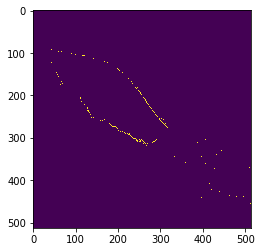

In [78]:
plt.imshow(data_X)

In [71]:
data_X_1 = transform_to_int(data_X, scaler)

In [72]:
data_X_1

array([[[256, 304],
        [256, 297],
        [257, 298],
        ...,
        [255, 306],
        [255, 297],
        [255, 297]]])

In [73]:
len(data_X_1)

1

In [82]:
def inference(X, Y, img_width, img_height, scaler, model):
    test_inference = []
    test_loss = []
    for i in range(len(X)):
        data_X = X[i] # shape = (1024,2)
        data_X = transform_to_int(data_X, scaler) # shape = (1024,2)
        data_X = convert_boundaries_to_image(data_X, img_width, img_height) # shape = (img_width, img_height)
        data_Y = Y[i]
        predict = model.predict(np.expand_dims(np.expand_dims(data_X, axis=0), axis=-1))
        loss = boundary_loss_np(data_Y, predict)
        test_inference.append(predict)
        test_loss.append(loss)
    test_inference = np.vstack(test_inference)
    test_loss = np.vstack(test_loss)
    return test_inference, test_loss

In [83]:
test_inference, test_loss = inference(boundary_sample_test, groundtruth_test,  513, 513, scaler, model)
train_inference, train_loss = inference(boundary_sample_train, groundtruth_train,  513, 513, scaler, model)
val_inference, val_loss = inference(boundary_sample_val, groundtruth_val,  513, 513, scaler, model)

In [84]:
cache_data((train_inference, val_inference, test_inference),
           os.path.join(predict_dir, 'inference_boundary.dat'))
cache_data((train_loss, val_loss, test_loss),
           os.path.join(predict_dir, 'inference_boundary_loss.dat'))

# End Inference Phase

In [85]:
train_loss, val_loss, test_loss = restore_data(os.path.join(predict_dir, 'inference_boundary_loss.dat'))

In [86]:
test_loss = np.asarray(test_loss)

In [87]:
np.mean(test_loss)

0.42188564702652737

In [88]:
inference_boundary = restore_data(os.path.join(predict_dir, 'inference_boundary.dat'))

In [89]:
train_inference, val_inference, test_inference = inference_boundary

In [90]:
test_inference.shape

(138, 513, 513, 1)

In [91]:
x = test_inference[0,:,:,0]
x.min(), x.max()

(-0.124027126, 1.4777223)

In [93]:
x = np.round(x)

In [96]:
a = np.where(x > 0.5, 1, 0)

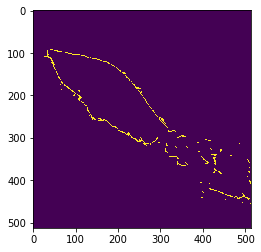

In [97]:
plt.imshow(a)

# Visualize boundaries groundtruth and predict overlay

In [99]:
visualize_dir = 'visualize/overlay_boundaries'
if not os.path.exists(visualize_dir):
    os.makedirs('visualize/overlay_boundaries')

In [109]:
def overlay_predict_groundtruth(groundtruth_boundaries, predict_boundaries, test_index,
                                cmap=plt.cm.Accent, alpha=0.5):
    plt.figure(figsize=(10,10))
    #predict_mask_lake = restore_data(os.path.join('mask_predict', '{}.dat'.format(test_index)))
    #groundtruth_mask_lake = restore_data(os.path.join('mask_groundtruth', '{}.dat'.format(test_index)))
    #predict_boundary = find_boundaries(predict_mask_lake).astype(np.uint8)
    #groundtruth_boundary = find_boundaries(groundtruth_mask_lake, mode='outer').astype(np.uint8)*3
    groundtruth_boundary = groundtruth_boundaries[test_index].astype(np.uint8)*3
    predict_boundary = predict_boundaries[test_index]
    if groundtruth_boundary.shape[-1] == 1:
        groundtruth_boundary = groundtruth_boundary.squeeze(axis=-1)
    if predict_boundary.shape[-1] == 1:
        predict_boundary = predict_boundary.squeeze(axis=-1)
    predict_boundary = np.round(predict_boundary).astype(np.uint8)
    a = predict_boundary + groundtruth_boundary
    print(a.min(), a.max())
    
    a[a==4] = 2
    # mask some 'bad' data, in your case you would have: data == 0
    a = np.ma.masked_where(a == 0, a)
    cmap.set_bad(color='white')
    plt.imshow(a, cmap=cmap)
    plt.savefig(os.path.join('visualize/overlay_boundaries/{}.png'.format(test_index)))
    
    print(a.min(), a.max())
    cbar = plt.colorbar()
    cbar.set_ticks(ticks=np.arange(4))
    cbar.set_ticklabels(['predict_only', 'predict_and_groundtruth', 'groundtruth_only'])

0 4
1 3


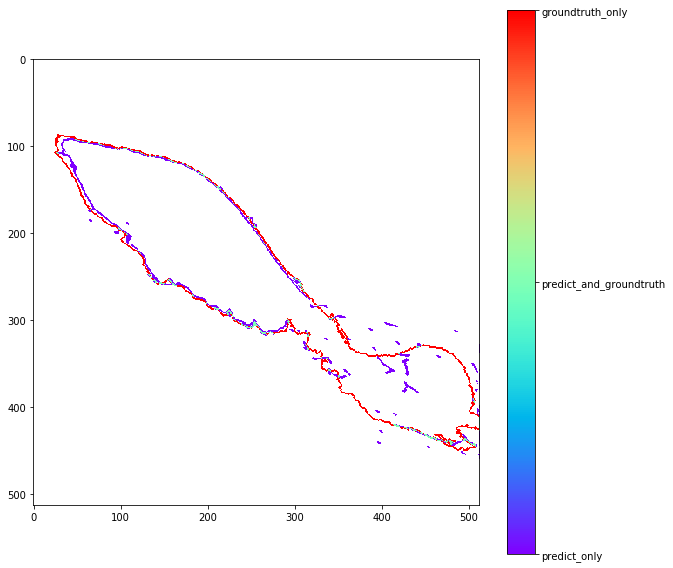

In [110]:
overlay_predict_groundtruth(groundtruth_test, test_inference, 0, plt.cm.rainbow)

In [34]:
groundtruth_boundary = groundtruth_test[0].astype(np.uint8)

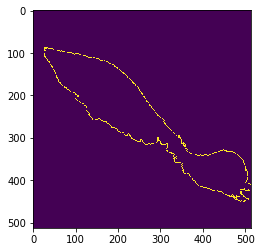

In [36]:
plt.imshow(groundtruth_boundary.squeeze(axis=-1))

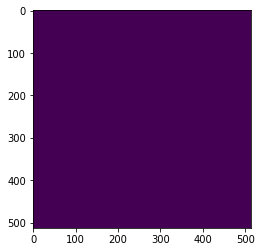

In [81]:
predict_boundary = test_inference[0].astype(np.uint8)
plt.imshow(predict_boundary.squeeze(axis=-1))

256